This is aimed at giving hands-on on PyTorch and training a neural network using one of the popular models, such as ResNet.

### Setup

Install the required package and import necessary libraries.

In [2]:
#!pip install torchprofile 1>/dev/null
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension
import sys
!{sys.executable} -m pip install torchprofile ipywidgets

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import random
from collections import OrderedDict, defaultdict

import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

Set the seeds to ensure reproducibility of results

In [4]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

### Prepara Dataset

We will use CIFAR-10 dataset in this tutorial. Read more about the dataset [here](https://urldefense.com/v3/__https://www.cs.toronto.edu/*kriz/cifar.html__;fg!!Mih3wA!FibehRwP1qJm7_Vc2HgRe3rVGBAOGU8NDGgCWy-awSldJISwMPAp28NSDtw_MPz32DMOD09lmDLr9JINM9lmeJmm2lU$ ).

In [5]:
# Further to this, change the transform for training data by removing
# inclusion of data augmentation such as RandomCrop and HorizontalFlip.  
# Check the differences in accuracy which these changes bring about.
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
transforms = {
  "train": Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
  ]),
  "val": ToTensor(),
  "test": ToTensor(),
}

dataset = {}

dataset["train"] = CIFAR10('data/cifar10', train=True, download=True,
                             transform=transforms["train"])

dataset["val"] = CIFAR10('data/cifar10', train=True, download=True,
                             transform=transforms["val"])

dataset["test"] = CIFAR10('data/cifar10', train=False, download=True,
                             transform=transforms["test"])

Defaulting to user installation because normal site-packages is not writeable
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: dejavu events execute kernel kernelspec lab
labextension labhub migrate nbclassic nbconvert notebook run server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


100%|██████████| 170498071/170498071 [01:41<00:00, 1687679.50it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified
Files already downloaded and verified


Visualize a few images in test dataset and their corresponding class labels

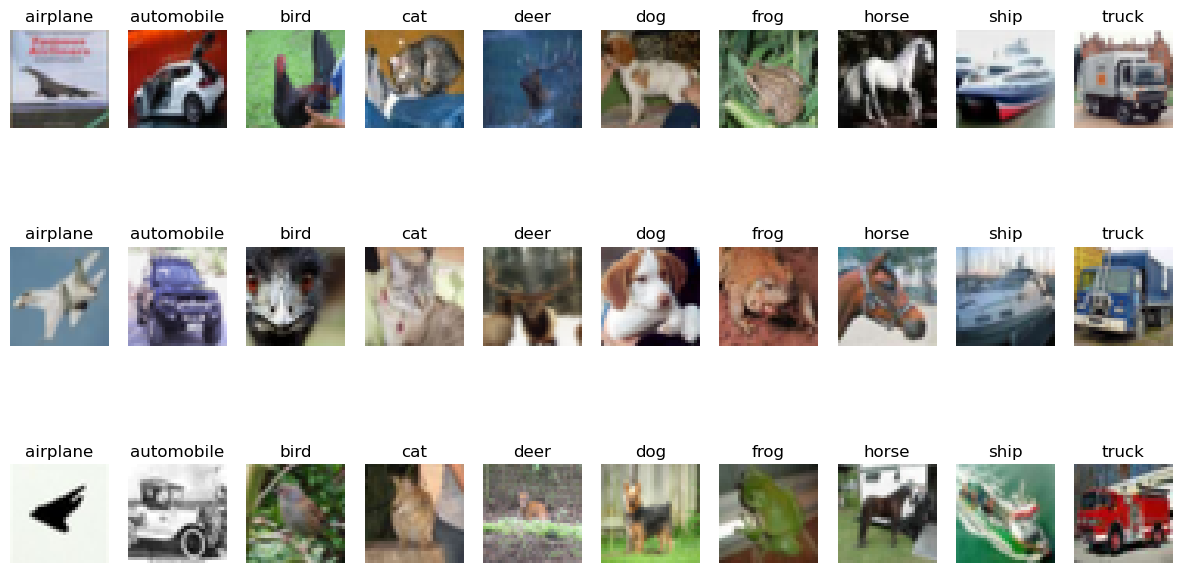

In [6]:
samples = [[] for _ in range(10)]
for image, label in dataset["test"]:
  if len(samples[label]) < 4:
    samples[label].append(image)

plt.figure(figsize=(15, 8))
for index in range(30):
  label = index % 10
  image = samples[label][index // 10]
  image = image.permute(1, 2, 0)

  # Convert from class index to class name
  label = dataset["test"].classes[label]

  # Visualize the image, 3 images for each of 10 labels
  plt.subplot(3, 10, index + 1)
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")
plt.show()

Create data loaders with a particular batch size.

In [7]:
# Batch size is an important parameter to be set for neural networks training.
# Change the batch_size parameter to other values (say 64, 128, 256, 1024) and 
# analyze the difference it brings about in accuracy.

dataflow    = {}
batch_size  = 512
for split in ['train', 'val', 'test']:
  dataflow[split] = DataLoader( dataset[split], batch_size = batch_size, shuffle = (split == 'train'), 
                               num_workers = 0, pin_memory = True,)

In [8]:
for inputs, targets in dataflow["train"]:
  print("[inputs] dtype: {}, shape: {}".format(inputs.dtype, inputs.shape))
  print("[targets] dtype: {}, shape: {}".format(targets.dtype, targets.shape))
  break

[inputs] dtype: torch.float32, shape: torch.Size([512, 3, 32, 32])
[targets] dtype: torch.int64, shape: torch.Size([512])


### Model

We will use [RESNET10](https://urldefense.com/v3/__https://arxiv.org/pdf/1512.03385.pdf__;!!Mih3wA!FibehRwP1qJm7_Vc2HgRe3rVGBAOGU8NDGgCWy-awSldJISwMPAp28NSDtw_MPz32DMOD09lmDLr9JINM9lmeNjAW2A$ ) as our model in this tutorial. The architecure of the model is shown below:

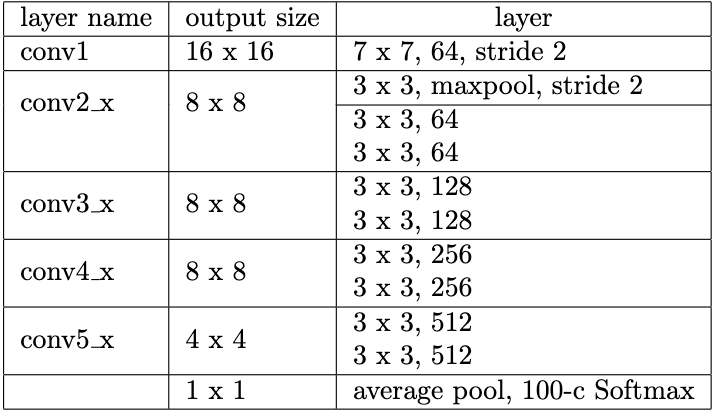

In [9]:
class RESNET(nn.Module):
  def __init__(self):
    super(RESNET, self).__init__()
    in_channel     = 3
    num_classes    = 10
    self.channel_1 = 64
    self.channel_2 = 128
    self.channel_3 = 256
    self.channel_4 = 512
    
    self.conv_1   = nn.Conv2d(in_channel, self.channel_1, (7,7), padding=3, stride=2)
    self.bn1      = nn.BatchNorm2d(self.channel_1)
    self.block_1  = nn.Sequential(
                    nn.Conv2d(self.channel_1, self.channel_1, (3,3), padding=1, stride=1),
                    nn.BatchNorm2d(self.channel_1),
                    nn.ReLU(),
                    nn.Conv2d(self.channel_1, self.channel_1, (3,3), padding=1, stride=1), 
                    )
    
    self.bn2      = nn.BatchNorm2d(self.channel_1)
    self.block_2  = nn.Sequential(
                    nn.Conv2d(self.channel_1, self.channel_2, (3,3), padding=1, stride=1), 
                    nn.BatchNorm2d(self.channel_2),
                    nn.ReLU(),
                    nn.Conv2d(self.channel_2, self.channel_2, (3,3), padding=1, stride=1),
                    )
    
    self.bn3          = nn.BatchNorm2d(self.channel_2)
    self.conv_2_skip  = nn.Conv2d(self.channel_1, self.channel_2, (1,1), stride=1)
    self.block_3      = nn.Sequential(
                        nn.Conv2d(self.channel_2, self.channel_3, (3,3), padding=1, stride=1),
                        nn.BatchNorm2d(self.channel_3),
                        nn.ReLU(),
                        nn.Conv2d(self.channel_3, self.channel_3, (3,3), padding=1, stride=1),
                        )
    
    self.bn4          = nn.BatchNorm2d(self.channel_3)
    self.conv_3_skip  = nn.Conv2d(self.channel_2, self.channel_3, (1,1), stride=1)
    self.block_4      = nn.Sequential(
                        nn.Conv2d(self.channel_3, self.channel_4, (3,3), padding=1, stride=2), 
                        nn.BatchNorm2d(self.channel_4),
                        nn.ReLU(),
                        nn.Conv2d(self.channel_4, self.channel_4, (3,3), padding=1, stride=1),
                        )
    
    self.bn5          = nn.BatchNorm2d(self.channel_4)
    self.conv_4_skip  = nn.Conv2d(self.channel_3, self.channel_4, (1,1), stride=2)
    
    self.relu     = nn.ReLU(inplace=True)
    self.maxpool  = nn.MaxPool2d((3,3), padding=1, stride=2)
    self.avgpool  = nn.AdaptiveAvgPool2d(output_size=(1,1))
    self.fc       = nn.Linear(self.channel_4, num_classes)

  def forward(self, x):
        
    x           = self.conv_1(x)
    
    # Batch Norm Implementation after conv1
    x           =  self.bn1(x)     
    x           = self.relu(x)
    maxpool_out = self.maxpool(x)
    x           = self.block_1(maxpool_out)
    
    # Batch Norm Implementation after conv2_x
    x           =  self.bn2(x)  
    block1_out  = x + maxpool_out # Skip connection after output of conv2_x
    x           = self.block_2(block1_out)
    
    # Batch Norm Implementation after conv3_x
    x           =  self.bn3(x)   
    block2_out  = x + self.conv_2_skip(block1_out) # Skip connection after output of conv3_x
    x           = self.block_3(block2_out)
    
    # Batch Norm Implementation after conv4_x
    x           =  self.bn4(x)   
    block3_out  = x + self.conv_3_skip(block2_out) # Skip connection after output of conv4_x
    x           = self.block_4(block3_out)
    
    # Batch Norm Implementation after conv5_x
    x           =  self.bn5(x)  
    block4_out  = x + self.conv_4_skip(block3_out) # Skip connection after output of conv5_x
    x           = self.avgpool(block4_out)
    
    x           = x.view(x.shape[0], -1)
    scores      = self.fc(x)
    
    return scores
  
model = RESNET().cuda()

Analyze model size (in terms of number of parameters to be trained) and computation cost. This will help us in analyzing the efficiency of the model.


In [10]:
num_params  = 0
num_macs    = 0
for parameter in model.parameters():
  if parameter.requires_grad:
    num_params += parameter.numel()
print("Number of Parameters to be trained:", num_params)

num_macs = profile_macs(model, torch.zeros(1, 3, 32, 32).cuda())
print("Number of MACs in this training:", num_macs)

Number of Parameters to be trained: 4912010
Number of MACs in this training: 139343360


### Optimization

Apply cross entropy as loss function to optimize the model. Use Stochastic Gradient Descent (SGD) with momentum as the optimizer.

In [11]:
# Learning rate of the optimizer is another important parameter which
# affects the accuracy achieved by the model. Change the value of 'lr' 
# parameter below and analyze the changes in accuracy. Possible values
# are 0.1, 1e-2, 1e-3.

# Further, try different optimizers like Adam and analyze the difference
# in accuracy it brings about. 

criterion = nn.CrossEntropyLoss()

optimizer = SGD(
  model.parameters(),
  lr=0.4,
  momentum=0.9,
  weight_decay=5e-4,
)

In [18]:
# Number of epochs used in the training is the third important parameter.
# Increase the number of epochs and analyze if it helps in increasing
# the validation accuracy of the model. 

num_epochs = 20
steps_per_epoch = len(dataflow["train"])

# Define the piecewise linear scheduler
lr_lambda = lambda step: np.interp(
  [step / steps_per_epoch],
  [0, num_epochs * 0.3, num_epochs],
  [0, 1, 0]
)[0]

scheduler = LambdaLR(optimizer, lr_lambda)

### Training

Define the training function and evaluation function. Evaluation function calculates the accuracy on the validation data set.

In [19]:
def train(
  model: nn.Module,
  dataflow: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
) -> None:
  model.train()

  for inputs, targets in tqdm(dataflow, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

In [20]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataflow: DataLoader
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataflow, desc="eval", leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Start training the model. This should take around 10-12 minutes and the model should achieve an accuracy of greater than 88%.

In [15]:
for epoch_num in tqdm(range(1, num_epochs + 1)):
  train(model, dataflow["train"], criterion, optimizer, scheduler)
  metric = evaluate(model, dataflow["val"])
  print(f"epoch {epoch_num}:", metric)

  0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 1: 35.641998291015625


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 2: 29.31399917602539


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 3: 38.305999755859375


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 4: 54.271995544433594


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 5: 53.358001708984375


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 6: 35.20399856567383


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 7: 49.6879997253418


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 8: 59.461997985839844


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 9: 58.063995361328125


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 10: 68.48999786376953


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 11: 70.65399932861328


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 12: 75.63600158691406


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 13: 69.17799377441406


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 14: 70.30999755859375


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 15: 74.81200408935547


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 16: 79.97599792480469


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 17: 78.68399810791016


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 18: 85.8740005493164


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 19: 87.83999633789062


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/98 [00:00<?, ?it/s]

epoch 20: 90.49199676513672


### Visualization

Visualize the performance of the trained model on test dataset.

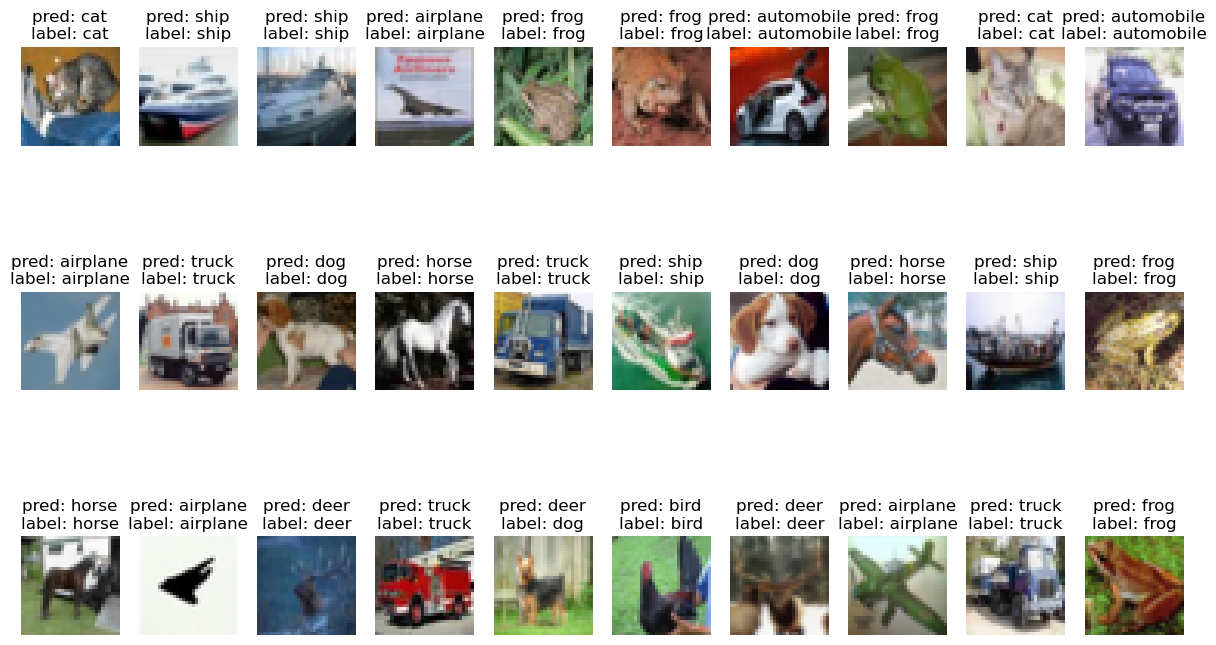

In [16]:
plt.figure(figsize=(15, 9))
for index in range(30):
  image, label = dataset["test"][index]

  # Model inference
  model.eval()
  with torch.inference_mode():
    pred = model(image.unsqueeze(dim=0).cuda())
    pred = pred.argmax(dim=1)

  image = image.permute(1, 2, 0)

  # Convert from class indices to class names
  pred = dataset["test"].classes[pred]
  label = dataset["test"].classes[label]

  # Visualize the image
  plt.subplot(3, 10, index + 1)
  plt.imshow(image)
  plt.title(f"pred: {pred}" + "\n" + f"label: {label}")
  plt.axis("off")
plt.show()

### Pytorch Lightning
Another tool you can use is PyTorch Lightning, a high-level framework that streamlines PyTorch code by abstracting the training loop and other boilerplate elements, enabling researchers and practitioners to focus on the core aspects of model development. You can find the documentation for it here:
https://lightning.ai/docs/pytorch/stable/